In [1]:
import time
start_time = time.time()

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models,Input,Model
import warnings
warnings.filterwarnings("ignore",category=UserWarning)
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

/Users/zhiqizhang/Desktop/continuous_policy/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def generate_features(N, C, D):
    continuous_features = np.zeros((N, C))
    for i in range(C):
        if i % 3 == 0:
            continuous_features[:, i] = np.random.normal(loc=0, scale=0.3,size=N)
        elif i % 3 == 1:
            continuous_features[:, i] = np.random.uniform(-1,1,size=N)
        else:
            continuous_features[:, i] = np.random.normal(loc=0, scale=0.3,size=N)
            # continuous_features[:, i] = np.random.gamma(shape=2, scale=1,size=N)
    binary_features = np.zeros((N,D))
    for i in range(D):
        binary_features[:,i]=np.random.choice([0,1],p=[0.5,0.5],size=N)
    return np.hstack((continuous_features, binary_features))
def generate_t(N):
    tvalues=[]
    for i in range(N):
        tvalues.append(random.choice([0,0.128,0.268,0.358,0.5]))
    return np.array(tvalues)

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

def abs_activation(x):
    return tf.math.abs(x)

def build_model(C, D):
    # Input layer
    input_layer = layers.Input(shape=(C + D,))
    # hidden1 = layers.Dropout(dropput_perc)(input_layer)
    # Hidden layers
    hidden1 = layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(input_layer)
    hidden2 = layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden1)
    hidden2 = layers.Dense(50, activation='relu', kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)

    # Output layers with abs_activation
    alpha = layers.Dense(1, activation=abs_activation, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)
    beta = layers.Dense(1, activation=abs_activation, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)
    theta = layers.Dense(1, activation=abs_activation, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)
    # gamma = layers.Dense(1, activation=abs_activation, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.5))(hidden2)
    gamma = layers.Dense(1, kernel_initializer=tf.keras.initializers.RandomUniform(-0.5, 0.4))(hidden2)
    # Extract features from input
    feature_c1 = layers.Lambda(lambda x: tf.expand_dims(x[:, C], axis=-1))(input_layer)
    feature_c2 = layers.Lambda(lambda x: tf.expand_dims(x[:, C + 1], axis=-1))(input_layer)

    # Gamma adjustment function
    def gamma_adjustment(inputs):
        gamma, feature_c1 = inputs
        gamma_adjust = gamma * (2*feature_c1-1)
        return gamma_adjust

    adjusted_gamma = layers.Lambda(gamma_adjustment, output_shape=(None, 1))([gamma, feature_c1])

    # Custom sensitivity scaling layer
    class SensitivityScalingLayer(layers.Layer):
        def call(self, inputs):
            alpha, beta, theta, sensitive = inputs
            scaling_factor = sensitive * 0.5 + 0.5
            adjusted_alpha = alpha * scaling_factor
            adjusted_beta = beta * scaling_factor
            adjusted_theta = theta * scaling_factor
            return adjusted_alpha, adjusted_beta, adjusted_theta

    # Apply sensitivity scaling
    adjusted_alpha, adjusted_beta, adjusted_theta = SensitivityScalingLayer()([alpha, beta, theta, feature_c2])

    # Define the model
    # model = models.Model(inputs=input_layer, outputs=[adjusted_alpha, adjusted_beta, adjusted_theta, adjusted_gamma])
    model = models.Model(inputs=input_layer,outputs =[alpha,beta,theta,gamma])
    return model


In [4]:
def predict_y(model, x, t):
    alpha,beta,theta,gamma = model.predict(x)
    alpha = alpha.reshape(-1)
    beta = beta.reshape(-1)
    theta = theta.reshape(-1)
    gamma = gamma.reshape(-1)

    # Calculate y using scaled t and updated alpha, beta, theta, and gamma
    y = t * t * t * alpha + beta * t * t + theta * t + gamma
    plt.hist(y)
    plt.show()
    y = 1 / (1 + np.exp(-y))  # Apply logistic to ensure outputs are in [0, 1]
    return y



In [5]:

C = 50  # Number of continuous variables
D = 20    # Number of binary discrete variables


In [6]:
N = 20000
exp_t_values = generate_t(N)
x = generate_features(N, C, D)

model_date_generation = build_model(50, 20)


In [7]:
alpha, beta,theta,gamma = model_date_generation.predict(x)
alpha = alpha.reshape(-1)
beta = beta.reshape(-1)
theta = theta.reshape(-1)
gamma = gamma.reshape(-1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


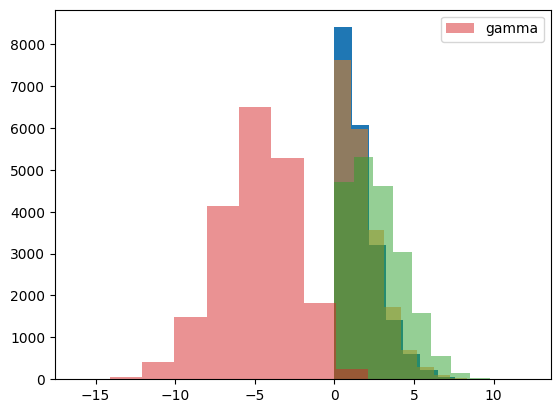

In [8]:
plt.hist(alpha)
plt.hist(beta,alpha=0.5)
plt.hist(theta,alpha=0.5)
plt.hist(gamma,alpha=0.5,label='gamma')
plt.legend()
plt.show()

In [9]:
alpha.mean(),beta.mean(),theta.mean(),gamma.mean()

(1.6230997, 1.7034098, 2.6556273, -4.8767905)

In [10]:
alpha.var(),beta.var(),theta.var(),gamma.var()

(1.7155877, 1.7851685, 3.0092816, 5.8279)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step


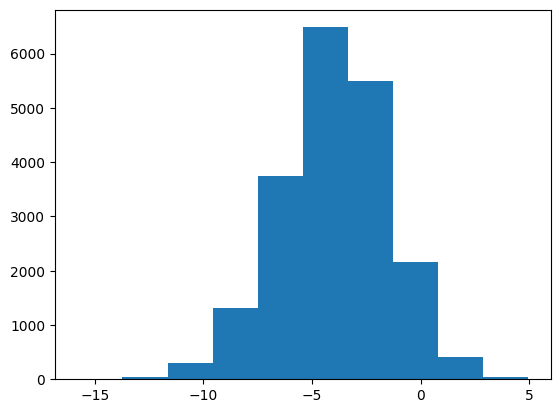

array([0.40899056, 0.02041665, 0.00499405, ..., 0.018604  , 0.07423797,
       0.00109759])

In [11]:
predicted_y = predict_y(model_date_generation, x, exp_t_values)
predicted_y

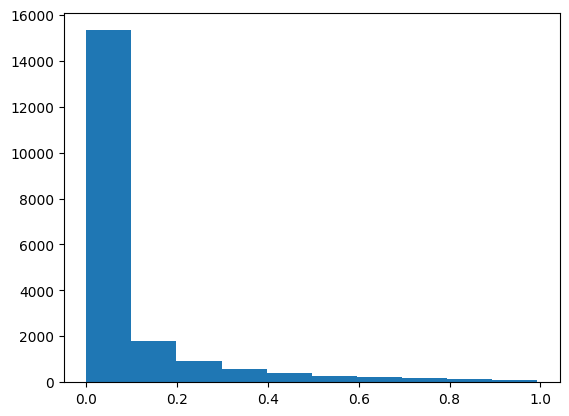

In [12]:
plt.hist(predicted_y)
plt.show()

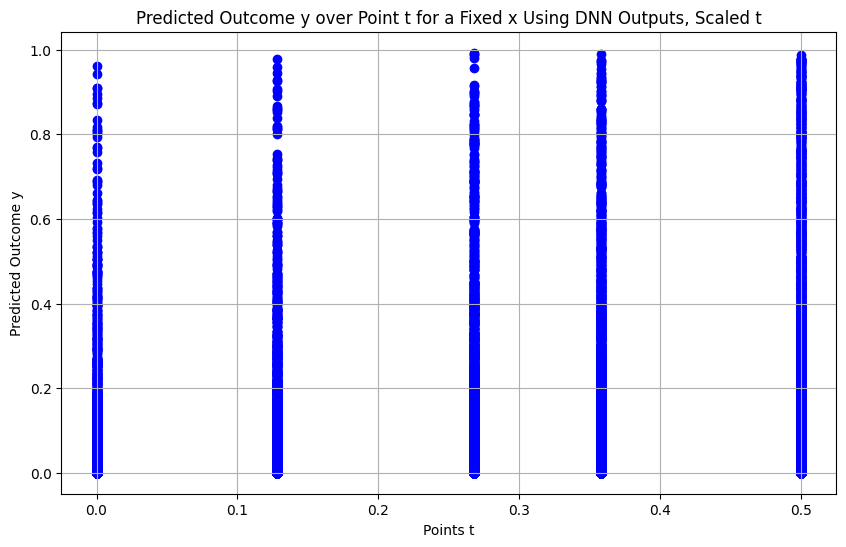

In [13]:

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(exp_t_values, predicted_y, color='blue')
plt.title('Predicted Outcome y over Point t for a Fixed x Using DNN Outputs, Scaled t')
plt.xlabel('Points t')
plt.ylabel('Predicted Outcome y')
plt.grid(True)
plt.show()

In [14]:
df = pd.DataFrame(x, columns=[f'Feature_{i+1}' for i in range(C + D)])
df['t'] = exp_t_values.flatten()
df['y'] = predicted_y
df['is_upload'] = 0

df.loc[df['y']>=0.5,'is_upload']=1

df['is_upload'].value_counts()

is_upload
0    19050
1      950
Name: count, dtype: int64

In [16]:
df['treatment']=0
df.loc[df['t']>0,'treatment']=1

In [17]:
for i in [0,0.128,0.268,0.358,0.5]:
    subdata1 = df.loc[(df['t']==0)|(df['t']==i)]
    res = sm.OLS.from_formula('is_upload ~ 1 + treatment', data=subdata1).fit()
#         print(res.get_robustcov_results().summary2(float_format="%.6f"))
    print('coef of intercept:', '%.8f'%res.params['Intercept'])
    print('coef of treatment:', '%.8f'%res.params['treatment'])
    print('pvalues of treatment:', '%.2f'%res.pvalues['treatment'])
    print('res:', '{:.2%}'.format(res.params['treatment']/res.params['Intercept']) )

coef of intercept: 0.01296435
coef of treatment: 0.00000000
pvalues of treatment: nan
res: 0.00%
coef of intercept: 0.01296435
coef of treatment: 0.00582323
pvalues of treatment: 0.04
res: 44.92%
coef of intercept: 0.01296435
coef of treatment: 0.02589510
pvalues of treatment: 0.00
res: 199.74%
coef of intercept: 0.01296435
coef of treatment: 0.04435089
pvalues of treatment: 0.00
res: 342.10%
coef of intercept: 0.01296435
coef of treatment: 0.09576346
pvalues of treatment: 0.00
res: 738.67%


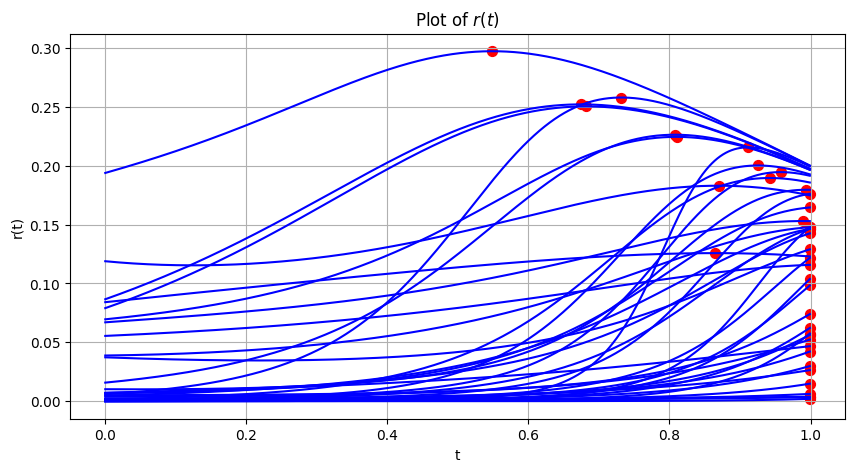

In [18]:
# Define the function y(t) and r(t)
def y(t,alpha,beta,theta,gamma):
    u =  t * t * t * alpha + beta * t * t + theta * t + gamma
    return 1 / (1 + np.exp(-u))
author_value = 0.3

def r(t,alpha,beta,theta,gamma):
    return y(t,alpha,beta,theta,gamma) * (0.5- author_value* t)

# Define the range for t
t_values = np.arange(0, 1, 0.001)



# Plotting
plt.figure(figsize=(10, 5))
for j in range(40):
    alpha0, beta0,theta0,gamma0 =alpha[j], beta[j],theta[j],gamma[j]
    r_values = r(t_values,alpha0,beta0,theta0,gamma0)
    max_r = np.max(r_values)
    max_t = t_values[np.argmax(r_values)]
    plt.plot(t_values, r_values, color='blue')
    plt.scatter(max_t, max_r, color='red', s=50)
plt.title("Plot of $r(t)$")
plt.xlabel("t")
plt.ylabel("r(t)")
plt.grid(True)
plt.show()


In [19]:
df.columns

Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15',
       'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20',
       'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25',
       'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30',
       'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35',
       'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40',
       'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45',
       'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50',
       'Feature_51', 'Feature_52', 'Feature_53', 'Feature_54', 'Feature_55',
       'Feature_56', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_60',
       'Feature_61', 'Feature_62', 'Feature_63', 'Feature_64', 'Feature_65',
       '

In [20]:
df['wrong_groupidx']=df.groupby([f'Feature_{C+3}',f'Feature_{C+4}']).ngroup()
df['right_groupidx']=df.groupby([f'Feature_{C+1}',f'Feature_{C+2}']).ngroup()
df['noise_groupidx']=df.groupby([f'Feature_{C+D-1}',f'Feature_{C+D}']).ngroup()
df['rightnoise_groupidx']=df.groupby([f'Feature_{C+1}',f'Feature_{C+D}']).ngroup()

In [21]:

optimal_values = []
optimal_t = []
for j in range(N):
    alpha0, beta0,theta0,gamma0 =alpha[j], beta[j],theta[j],gamma[j]
    r_values = r(t_values,alpha0,beta0,theta0,gamma0)
    max_r = np.max(r_values)
    max_t = t_values[np.argmax(r_values)]
    optimal_values.append(max_r)
    optimal_t.append(max_t)

In [22]:
df['optimal_t'] = optimal_t
df['optimal_r'] = optimal_values
df[['optimal_t','optimal_r']]

,optimal_t,optimal_r
0,0.870,0.183038
1,0.993,0.179595
2,0.999,0.121687
3,0.999,0.006215
4,0.999,0.014907
...,...,...
19995,0.917,0.204300
19996,0.999,0.036721
19997,0.999,0.054205
19998,0.794,0.244823


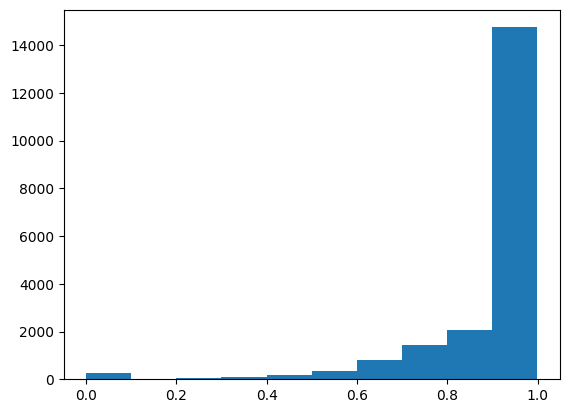

In [23]:
plt.hist(df['optimal_t'])
plt.show()

In [24]:
df.groupby([f'Feature_{C+1}',f'Feature_{C+2}'])['optimal_t'].agg({'mean','std'})

mean       std
Feature_51 Feature_52                    
0.0        0.0         0.916086  0.161439
           1.0         0.911009  0.179723
1.0        0.0         0.920960  0.142792
           1.0         0.910048  0.179674

In [25]:
tvar=['t']
xvar = [f'Feature_{i+1}' for i in range(C + D)]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


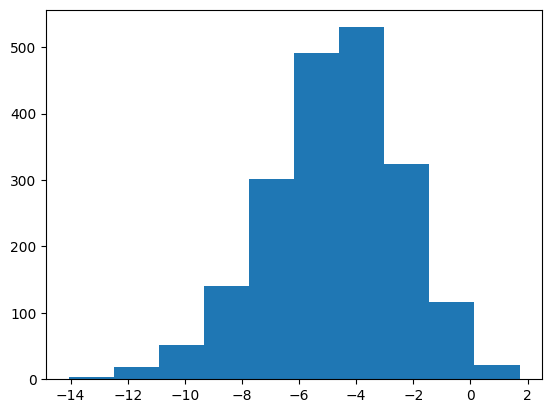

In [26]:
#generate validation data
N_test = 2000
x_validation = generate_features(N_test, C, D)

alpha_val, beta_val,theta_val,gamma_val = model_date_generation.predict(x_validation)


alpha_val = alpha_val.reshape(-1)
beta_val = beta_val.reshape(-1)
theta_val = theta_val.reshape(-1)
gamma_val = gamma_val.reshape(-1)
optimal_values = []
optimal_t = []

val_y = predict_y(model_date_generation, x_validation, np.zeros(N_test))

for j in range(N_test):
    alpha0, beta0,theta0,gamma0 =alpha_val[j], beta_val[j],theta_val[j],gamma_val[j]
    r_values = r(t_values,alpha0,beta0,theta0,gamma0)
    max_r = np.max(r_values)
    max_t = t_values[np.argmax(r_values)]
    optimal_values.append(max_r)
    optimal_t.append(max_t)
df_val = pd.DataFrame(x_validation, columns=[f'Feature_{i+1}' for i in range(C + D)])
df_val['optimal_t'] = optimal_t
df_val['optimal_r'] = optimal_values
df_val['y']=val_y
df_val[tvar]=0.0

In [27]:
df_train,df_test = train_test_split(df.sample(20000),test_size=1/2, random_state=5293)

df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

dnn_x_train = df_train[xvar]
dnn_t_train = df_train[tvar]
dnn_y_train = df_train['is_upload'].astype('int')
printedResult_2000=[]

## DLPT

In [28]:
def dnn_cubic(xvar,tvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    input2_ = Input(shape=(len(tvar),),name='treatment_input')

    t_sq = layers.Multiply()([input2_,input2_])
    t3 = layers.Multiply()([input2_,t_sq])

    a = layers.Dense(10,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal())(input1_)
    a = layers.Dense(10,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal())(a)
    a = layers.Dense(10,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal())(a)
    paraa = layers.Dense(1,name='parameter_a')(a)
    parab = layers.Dense(3,name='parameter_bcd')(a)

    t = layers.concatenate([input2_,t_sq,t3])
    def custom_multiply_and_sum(inputs):
        parab, t = inputs
        return tf.reduce_sum(parab * t, axis=-1, keepdims=True) 

    bbt = tf.keras.layers.Lambda(custom_multiply_and_sum)([parab, t])
    abcdt = layers.Add(name='u')([paraa,bbt])

    output_ = layers.Dense(1,use_bias = False,trainable=False,activation='sigmoid',
                   kernel_initializer = tf.keras.initializers.constant(1),
                   name='sigmoid_function')(abcdt)
#     output_ = layers.Dense(1,use_bias=False,name='output_sigmoid')(output_)
    model = Model(inputs=[input1_,input2_],outputs=[output_])
    model.summary()
    return model
model_cubic_random_mask = dnn_cubic(xvar,tvar)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_input       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        710 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │        110 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ treatment_input[… │
│                     │                   │            │ treatment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 10)        │        110 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1)         │          0 │ treatment_input[… │
│ (Multiply)          │                   │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ parameter_bcd       │ (None, 3)         │         33 │ dense_9[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ treatment_input[… │
│ (Concatenate)       │                   │            │ multiply[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ parameter_a (Dense) │ (None, 1)         │         11 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1)         │          0 │ parameter_bcd[0]… │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u (Add)             │ (None, 1)         │          0 │ parameter_a[0][0… │
│                     │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_function    │ (None, 1)         │          1 │ u[0][0]           │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 975 (3.81 KB)

 Trainable params: 974 (3.80 KB)

 Non-trainable params: 1 (4.00 B)

In [29]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [30]:
loss = tf.keras.losses.BinaryCrossentropy()
from tensorflow.keras.optimizers import Adagrad,Adam,SGD
# opt = SGD(learning_rate=0.005)


def weighted_mse_class(class_weights):
    def loss_fn(y_true, y_pred):
        weights = tf.where(tf.equal(y_true, 1), class_weights[1], class_weights[0])
        error = tf.square(y_true - y_pred)
        weighted_error = weights * error
        return tf.reduce_mean(weighted_error)
    return loss_fn

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=dnn_y_train.unique(),
    y=dnn_y_train
)
# class_weights = {0:np.mean(dnn_y_train), 1: (1-np.mean(dnn_y_train))}
# class_weights = np.log(class_weights+1)
# class_weights = dict(zip(np.array([0,1]), class_weights))
class_weights = {0:1,1:1}
loss_fn = weighted_mse_class(class_weights)

# model_cubic_random_mask.compile(optimizer = opt,loss = loss,metrics=METRICS)

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitors validation loss
    patience=20,           # Number of epochs with no improvement after which to stop
    restore_best_weights=True  # Restores the best weights after stopping
)

from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch, lr):
    # Reduce learning rate by half every 8 epochs
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.5
    return lr
def exponential_decay(epoch, lr):
    initial_lr = 0.01
    k = 0.05  # Decay rate
    return initial_lr * np.exp(-k * epoch)

lr_scheduler = LearningRateScheduler(exponential_decay)

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_cubic_random_mask.compile(optimizer = opt,loss = 'mse',metrics=METRICS)
history = model_cubic_random_mask.fit([dnn_x_train,dnn_t_train],dnn_y_train,epochs=200,batch_size=32,\
                                      validation_split=0.1,callbacks=[early_stopping])

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9460 - auc: 0.4968 - fn: 201.8940 - fp: 27.7951 - loss: 0.1116 - prc: 0.0656 - precision: 0.1473 - recall: 0.0394 - tn: 4309.2935 - tp: 4.7350 - val_accuracy: 0.9500 - val_auc: 0.4422 - val_fn: 50.0000 - val_fp: 0.0000e+00 - val_loss: 0.0744 - val_prc: 0.0445 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 950.0000 - val_tp: 0.0000e+00
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.9561 - auc: 0.4896 - fn: 196.2262 - fp: 0.0000e+00 - loss: 0.0612 - prc: 0.0507 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 4347.4912 - tp: 0.0000e+00 - val_accuracy: 0.9500 - val_auc: 0.4590 - val_fn: 50.0000 - val_fp: 0.0000e+00 - val_loss: 0.0568 - val_prc: 0.0452 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 950.0000 - val_tp: 0.0000e+00
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.9547 - auc: 0.4968 - fn: 204.3463 - fp: 0.0000e+00 - loss: 0.0498 - prc: 0

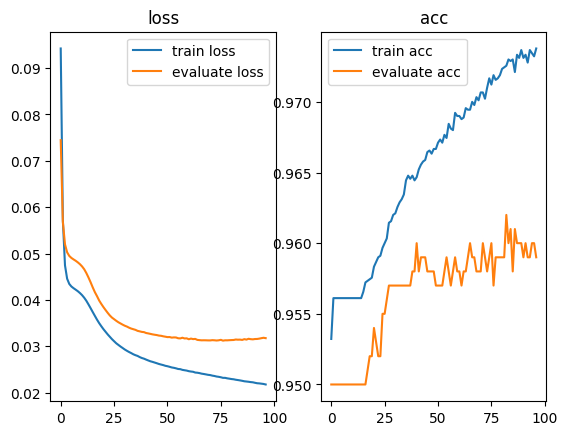

In [31]:
loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
plt.figure()
plt.subplot(121)
plt.plot(loss,label='train loss')
plt.plot(val_loss,label = 'evaluate loss')
plt.legend()
plt.title('loss')
plt.subplot(122)
plt.plot(acc,label='train acc')
plt.plot(val_acc,label = 'evaluate acc')
plt.legend()
plt.title('acc')
plt.show()



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step


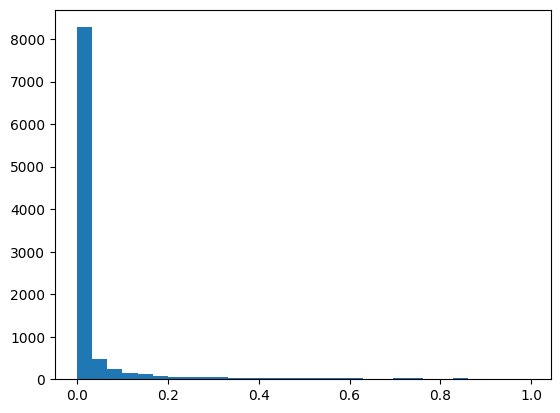

In [32]:
pdl_predict_y = model_cubic_random_mask.predict([np.array(df_test[xvar]),np.array(df_test[tvar])])
df_test['pred_y_dml']=pdl_predict_y.reshape(-1)
plt.hist(pdl_predict_y,bins=30)
plt.show()

In [33]:
#get lambdax

x_train_s = df_test
modelu = Model(inputs=model_cubic_random_mask.input, outputs=model_cubic_random_mask.get_layer('u').output)
dnn_x_test = x_train_s[xvar]
f = x_train_s.groupby(tvar)['Feature_1'].count().reset_index()
sumt = f['Feature_1'].sum()
F_list = f['Feature_1']/sumt

aa2 = np.zeros((len(x_train_s),4,4))

# use binary crossentropy as loss
# for i in range(len(f)):
#     t = f[tvar[0]][i]
#     tildet = np.hstack((1,t,t*t,t*t*t))#[1,t,t^2]
#     u = np.array(modelu.predict([x_train_s[xvar],np.array([t]*len(x_train_s))])).reshape(-1)
#     for j in range(len(x_train_s)):
#         # loss_weights = x_train_s['is_upload'][j]*class_weights[1] + (1- x_train_s['is_upload'][j])*class_weights[0]
#         l_pp = (np.exp(-u[j])/((1+np.exp(-u[j]))**2))*np.outer(tildet,tildet)*F_list[i]
#         aa2[j] += l_pp




In [34]:
#use mse as loss
for i in range(len(f)):
    t = f[tvar[0]][i]
    tildet = np.hstack((1,t,t*t,t*t*t))#[1,t,t^2]
    u = np.array(modelu.predict([x_train_s[xvar],np.array([t]*len(x_train_s))])).reshape(-1)
    for j in range(len(x_train_s)):
        # loss_weights = x_train_s['is_upload'][j]*class_weights[1] + (1- x_train_s['is_upload'][j])*class_weights[0]
        g_prime =  (np.exp(-u[j])/((1+np.exp(-u[j]))**2))*tildet
        l_pp =np.outer(g_prime,g_prime)*F_list[i]
        aa2[j] += l_pp

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


In [35]:
#lambdax_inv2
cc2=np.zeros((len(x_train_s),4,4))
notinv=[]
for i in range(aa2.shape[0]):
    try:
        cc2[i]=np.linalg.inv(aa2[i]+0.01*np.eye(aa2[0].shape[0]))
        # cc2[i]=np.linalg.pinv(aa2[i])
    except:
        notinv.append(i)
        cc2[i]=np.linalg.inv(aa2[i]+0.005*np.eye(aa2[0].shape[0]))
print('lambda inv done.')
print(len(notinv))

lambda inv done.
0


In [36]:
#get estimators
def g(u):
    return 1/(1+np.exp(-u))
def g_dao(u):
    return np.exp(-u)/((np.exp(-u)+1)**2)
def get_estimates_cubic(model,x_train_s,cc2):
    # Ensure correct shape for inputs
    dnn_x_test = np.array(x_train_s[xvar])

    # dnn_x_test = x_train_s[xvar]
    y0 = model.predict([dnn_x_test, np.array([0]*len(dnn_x_test))])
    u0 = modelu.predict([dnn_x_test, np.array([0]*len(dnn_x_test))])
    n = len(y0)



    #dnn*5
    meanlist=[]
    mselist=[]
    upperlist=[]
    lowerlist=[]
    no_revise_meanlist=[]
    no_revise_mselist=[]
    no_revise_upperlist=[]
    no_revise_lowerlist=[]

    #record result
    resdf = pd.DataFrame()


    prey_real = model.predict([dnn_x_test, np.array(x_train_s[tvar])])
    preu_real = modelu.predict([dnn_x_test, np.array(x_train_s[tvar]).reshape(-1)])
    exp_t_values = [0,0.128,0.388,0.538,0.938]
    for unobs_t in exp_t_values[1:]:
    
        # dnn_t_test = np.array([unobs_t]*len(x_train_s))
        dnn_t_test = np.array([unobs_t] * len(x_train_s)).reshape(-1, len(tvar))
        exp_preu = modelu.predict([dnn_x_test,dnn_t_test.reshape(-1)])
        exp_prey = model.predict([dnn_x_test,dnn_t_test])

        result_df = pd.DataFrame()
        result_df['preu']=np.array(exp_preu).reshape(-1)
        result_df['exp_prey']=exp_prey.reshape(-1)

        result_df['preuu0']=u0.reshape(-1)
        result_df['preyu0']=y0.reshape(-1)
        result_df['dGu0']= g_dao(np.array(result_df['preuu0']))
        result_df['dGu'] = g_dao(np.array(result_df['preu']))
        result_df['Gu0'] = g(np.array(result_df['preuu0']))
        result_df['Gu']  = g(np.array(result_df['preu']))

        result_df['y']=np.array(x_train_s['is_upload']).reshape(-1)

        result_df['prey_real']=prey_real.reshape(-1)
        result_df['preu_real']=preu_real.reshape(-1)
        result_df['dGpreu_real']=g_dao(np.array(result_df['preu_real']))

        # result_df['loss_weight']=result_df['y']*class_weights[1] + (1-result_df['y'])*class_weights[0]
        # result_df['g_y']=(result_df['prey_real']-result_df['y'])*result_df['loss_weight']
        result_df['g_y']=(result_df['prey_real']-result_df['y'])

        result_df['dh1']=result_df['dGu']-result_df['dGu0']
        result_df['dht1']=result_df['dGu']*unobs_t
        result_df['dht2']=result_df['dGu']*unobs_t*unobs_t
        result_df['dht3']=result_df['dGu']*unobs_t*unobs_t*unobs_t


        result_df['l1'] = result_df['g_y']*result_df['dGpreu_real']
        # result_df['l1'] = result_df['g_y']

        result_df['lt1'] = np.array(x_train_s[tvar]).reshape(-1)*np.array(result_df['l1']).reshape(-1)
        result_df['lt2'] = np.array(x_train_s[tvar]).reshape(-1)*np.array(result_df['lt1']).reshape(-1)
        result_df['lt3'] = np.array(x_train_s[tvar]).reshape(-1)*np.array(result_df['lt2']).reshape(-1)

        n=len(result_df)
        array1 = np.array(result_df[['dh1','dht1','dht2','dht3']]) #dH
        array2 = cc2.copy()                        #lambda x inv
        array6 =  np.array(result_df[['l1','lt1','lt2','lt3']]) #dl
        tri_multi = []

        for j in range(n):
            tri_multi.append(np.dot(array1[j].reshape(1,4),np.dot(array2[j],array6[j].reshape(4,1))))


        result_df['tri']=np.array(tri_multi).reshape(-1)
        no_revise_est = result_df['exp_prey'] - result_df['preyu0']
        est = result_df['exp_prey'] - result_df['preyu0'] -  result_df['tri']

        resdf[f'norevise_combo_{unobs_t}'] = no_revise_est
        resdf[f'revise_combo_{unobs_t}'] = est
        resdf[f'tri_{unobs_t}']=result_df['tri']

        print(unobs_t)
        no_revise_mean = no_revise_est.mean()
        no_revise_mse = ((no_revise_est-no_revise_est.mean())**2).mean()
        no_revise_lower = no_revise_mean-1.96*no_revise_mse/np.sqrt(n)
        no_revise_upper = no_revise_mean+1.96*no_revise_mse/np.sqrt(n)
        print("no revise====")
        print(no_revise_mean,no_revise_mse,no_revise_lower,no_revise_upper)
        no_revise_meanlist.append(no_revise_mean)
        no_revise_mselist.append(no_revise_mse)
        no_revise_lowerlist.append(no_revise_lower)
        no_revise_upperlist.append(no_revise_upper)

        mean = est.mean()
        meanlist.append(mean)
        mse = ((est-est.mean())**2).mean()
        mselist.append(mse)
        lower = mean-1.96*mse/np.sqrt(n)
        lowerlist.append(lower)
        upper = mean+1.96*mse/np.sqrt(n)
        upperlist.append(upper)
        print("revise====")
        print(mean,mse,lower,upper)

    sumtable = pd.DataFrame({'combo':[1,2,3,4],'diff':meanlist,'mse':mselist,'upper':upperlist,'lower':lowerlist})
    no_revise_sumtable = pd.DataFrame({'combo':[1,2,3,4],'diff':no_revise_meanlist,'mse':no_revise_mselist,'upper':no_revise_upperlist,'lower':no_revise_lowerlist})
    return sumtable,no_revise_sumtable,resdf

In [37]:
# df4,df5,df6 = get_estimates_cubic(model_cubic_random_mask,df_test,cc2)

In [38]:
# find optimal
#get lambda x inverse: cc2
#get ltheta:
modela = Model(model_cubic_random_mask.input,model_cubic_random_mask.get_layer('parameter_a').output)
modelb = Model(model_cubic_random_mask.input,model_cubic_random_mask.get_layer('parameter_bcd').output)
resdf = pd.DataFrame()
resdf['a'] = modela.predict([df_test[xvar],np.array([0]*len(df_test))]).reshape(-1)
a = np.array(resdf['a'])
b = modelb.predict([df_test[xvar],np.array([0]*len(df_test))])
resdf['b1'] = b[:,0]
resdf['b2'] = b[:,1]
resdf['b3'] = b[:,2]
resdf['prey_real'] = model_cubic_random_mask.predict([df_test[xvar],df_test[tvar]]).reshape(-1)
resdf['preu_real'] = modelu.predict([df_test[xvar],np.array(df_test[tvar]).reshape(-1)]).reshape(-1)

resdf['dGpreu_real']=g_dao(np.array(resdf['preu_real']))

resdf['y'] = df_test['y']
# resdf['loss_weight']=resdf['y']*class_weights[1] + (1-resdf['y'])*class_weights[0]
# resdf['g_y'] =(resdf['prey_real']-resdf['y'])
resdf['g_y'] =(resdf['prey_real']-resdf['y'])
resdf['l1'] = resdf['g_y']*resdf['dGpreu_real']
# resdf['l1'] = resdf['g_y']
resdf['lt1'] = np.array(df_test[tvar]).reshape(-1)*np.array(resdf['l1']).reshape(-1)
resdf['lt2'] = np.array(df_test[tvar]).reshape(-1)*np.array(resdf['lt1']).reshape(-1)
resdf['lt3'] = np.array(df_test[tvar]).reshape(-1)*np.array(resdf['lt2']).reshape(-1)
ltheta = np.array(resdf[['l1','lt1','lt2','lt3']])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step


In [39]:
resdf[['a','b1','b2','b3']].mean()

a    -8.138443
b1    4.251693
b2    3.898081
b3   -3.867286
dtype: float32

In [40]:
#method1: use discretized t set to find
def g(u):
    return 1 / (1 + np.exp(-u))

def g_dao(u):
    return np.exp(-u) / ((np.exp(-u) + 1) ** 2)

def ufunc1(t, a, b1, b2, b3):
    return a + b1 * t + b2 * t *t + b3 * t *t*t

def gtheta(u, t):
    dgu = g_dao(u)
    res = np.vstack(([dgu], [dgu * t], [dgu * t ** 2], [dgu * t ** 3]))
    res = np.transpose(res)
#     res = res.reshape((len(df_test),1,4))
    return res

def objective(t_set, i, a, b, cc2, ltheta):
    aa = a[i]
    bb1 = b[i, 0]
    bb2 = b[i, 1]
    bb3 = b[i, 2]
    uu = ufunc(t_set, aa, bb1, bb2, bb3)
    gtheta_u = gtheta(uu, t_set)
    gu = g(uu)
    psi_value=[]
    for j in range(len(t_set)):
        tempt = t_set[j]
        psi = gu[j]-np.dot(gtheta_u[j,:].reshape(1,4),np.dot(cc2[i],ltheta[i].reshape(4,1)))
        psi_value.append(psi)

    return np.array(gu).reshape(-1),np.array(psi_value).reshape(-1)

In [41]:
ltheta = ltheta.reshape((len(df_test),4,1))

In [42]:
import numpy as np

def g(u):
    return 1 / (1 + np.exp(-u))

def g_dao(u):
    return np.exp(-u) / ((np.exp(-u) + 1) ** 2)
    # return g(u)*(1-g(u))

def ufunc(t, a, b1, b2, b3):
    return a[:, None] + b1[:, None] * t + b2[:, None] * t**2 + b3[:, None] * t**3

def gtheta(u, t):
    dgu = g_dao(u)
    return np.stack((dgu, dgu * t, dgu * t**2, dgu * t**3), axis=-1)

def objective(t_set, a, b, cc2, ltheta):
    uu = ufunc(t_set, a, b[:, 0], b[:, 1], b[:, 2])
    gu = g(uu)
    gtheta_u = gtheta(uu, t_set)

    # Using broadcasting and tensor dot product
    cc2_dot_ltheta = np.matmul(cc2, ltheta)  # Shape will be (num_samples, 4, 1)
    psi = gu - np.matmul(gtheta_u, cc2_dot_ltheta)[:, :, 0]  # Remove last dimension and align shapes

    return gu, psi.squeeze()
# Define your parameters

# Call the objective function without the loop
gu, psi = objective(t_values, a, b, cc2, ltheta)

psi_array_DLPT = psi  # Transpose to match the expected shape (num_samples, len(t_values))
psi_array_SDL = gu  # Assuming you need the same values here; adjust if necessary
SDL_value_array = psi_array_SDL*(0.5 - author_value*t_values)
DLPT_value_array=psi_array_DLPT*(0.5 - author_value*t_values)
df_test['learned_SDL_policy'] = np.argmax(SDL_value_array,axis=1)
df_test['SDL_est_policy_value'] = np.max(SDL_value_array,axis=1)
df_test['learned_DLPT_policy'] = np.argmax(DLPT_value_array,axis=1)
df_test['DLPT_est_policy_value'] = np.max(DLPT_value_array,axis=1)

In [43]:
df_test['optimal_r'].mean(),df_test['DLPT_est_policy_value'].mean(),df_test['SDL_est_policy_value'].mean()

(0.13306642849121478, 0.06329834336956089, 0.05506015760820901)

In [44]:
cc2 = tf.cast(cc2,tf.float32)
ltheta = tf.cast((ltheta),tf.float32)

In [45]:
## define policy class t=f(v,x),f is a fixed size dnn
from keras.initializers import GlorotUniform,LecunNormal,HeNormal
def DNN_policy_class(xvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    a = layers.Dense(20,activation='relu')(input1_)
    a = layers.Dense(20,activation='relu')(a)
    a = layers.Dense(20,activation='relu')(a)
    output_ = layers.Dense(1)(a)
    model = Model(inputs=[input1_],outputs=[output_])
    model.summary()
    return model
def linear_policy_class(xvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    output_ = layers.Dense(1,kernel_initializer = HeNormal())(input1_)
    model = Model(inputs=[input1_],outputs=[output_])
    model.summary()
    return model   
def custom_loss(t,a ,b,cc2,ltheta):
    uu = ufunc1(t,a,b[:,0],b[:,1],b[:,2])
    gtheta_u = gtheta(uu, t)
    nan_mask = np.isnan(gtheta_u)
    gtheta_u[nan_mask]=0
    gtheta_u = tf.cast(gtheta_u,tf.float32)
    gtheta_u = tf.reshape(gtheta_u, ((len(df_test), 1, 4)))
    gu = g(uu)
    cc2new = tf.matmul(cc2,ltheta)
    debias_term  = tf.matmul(gtheta_u,cc2new)
    debias_term = tf.squeeze(debias_term)
    nan_mask = tf.math.is_nan(debias_term)
    debias_term = tf.where(nan_mask, tf.zeros_like(debias_term), debias_term)
    psi = gu  - debias_term
    sdl_psi = gu
    psi = tf.clip_by_value(psi, 0, 1)
#     value = tf.nn.relu(psi)*tf.nn.relu(0.5-0.1*t)
    value = psi*(0.5-author_value*t)
    sdl_value = sdl_psi*(0.5-author_value*t)
    print(value)
    return -tf.reduce_mean(value), -tf.reduce_mean(sdl_value)
def train_step(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss(predictions,a ,b,cc2,ltheta)[0]
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [46]:
# Instantiate the model
# DLPT_policy = DNN_policy_class(xvar)
DLPT_policy = linear_policy_class(xvar)
DLPT_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
DLPT_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=100,batch_size = 32)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - loss: 0.5535 - mae: 0.5940
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 0.1273 - mae: 0.2846
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - loss: 0.0514 - mae: 0.1815
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - loss: 0.0356 - mae: 0.1509
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - loss: 0.0302 - mae: 0.1386
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - loss: 0.0267 - mae: 0.1293
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step - loss: 0.0248 - mae: 0.1242
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - loss: 0.0239 - mae: 0.1203
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step - loss: 0.0222 - mae: 0.1152
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 0.0217 - mae: 0.1137
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - loss: 0.0205 - mae: 0.1094
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - loss: 0.0197 - m

In [47]:
# Optimizer
import tensorflow as tf
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)

# Training parameters
num_epochs = 1000
inputs = np.array(df_test[xvar])

In [48]:
# Training loop
loss_history = []
patience = 10  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step(DLPT_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

# Print the final model parameters
for var in DLPT_policy.trainable_variables:
    print(var.name, var.numpy())


tf.Tensor(
[1.5709479e-06 1.0558047e-02 1.0319604e-01 ... 5.7478395e-05 2.7446501e-02
 1.4174688e-03], shape=(10000,), dtype=float32)
Epoch 0: Loss: -0.05258264020085335
tf.Tensor(
[1.57105831e-06 1.05570629e-02 1.03187256e-01 ... 5.74781079e-05
 2.74457838e-02 1.41746143e-03], shape=(10000,), dtype=float32)
Epoch 1: Loss: -0.0525827631354332
tf.Tensor(
[1.5711719e-06 1.0556063e-02 1.0317849e-01 ... 5.7477810e-05 2.7445072e-02
 1.4174542e-03], shape=(10000,), dtype=float32)
Epoch 2: Loss: -0.05258287489414215
tf.Tensor(
[1.57128250e-06 1.05550708e-02 1.03169724e-01 ... 5.74775077e-05
 2.74443533e-02 1.41744781e-03], shape=(10000,), dtype=float32)
Epoch 3: Loss: -0.0525829941034317
tf.Tensor(
[1.5713961e-06 1.0554079e-02 1.0316093e-01 ... 5.7477217e-05 2.7443636e-02
 1.4174419e-03], shape=(10000,), dtype=float32)
Epoch 4: Loss: -0.052583105862140656
tf.Tensor(
[1.5715063e-06 1.0553084e-02 1.0315216e-01 ... 5.7476984e-05 2.7442921e-02
 1.4174347e-03], shape=(10000,), dtype=float32)
Epoch

In [49]:
DLPT_policy2 = DNN_policy_class(xvar)
DLPT_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
DLPT_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=100,batch_size = 32)
# Training loop
loss_history = []
patience = 1  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
for epoch in range(num_epochs):
    loss = train_step(DLPT_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0



Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 20)             │         1,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281 (8.91 KB)

 Trainable params: 2,281 (8.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 0.1080 - mae: 0.2503
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 0.0247 - mae: 0.1220
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 0.0202 - mae: 0.1092
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 0.0171 - mae: 0.0980
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 0.0126 - mae: 0.0826
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.0084 - mae: 0.0671
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 0.0067 - mae: 0.0597
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 0.0062 - mae: 0.0573
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.0055 - mae: 0.0534
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.0052 - mae: 0.0527
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 0.0053 - mae: 0.0529
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step - loss: 0.0050 - m

In [50]:
#same for SDL
#within same policy class
# SDL_policy = DNN_policy_class(xvar)
SDL_policy =linear_policy_class(xvar)
SDL_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
SDL_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_SDL_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
def train_step_sdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss(predictions,a ,b,cc2,ltheta)[1]
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3 # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_sdl(SDL_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - loss: 0.4009 - mae: 0.5066
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.1999 - mae: 0.3576
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.1285 - mae: 0.2865
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 0.0841 - mae: 0.2327
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 0.0598 - mae: 0.1953
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 0.0453 - mae: 0.1709
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 0.0377 - mae: 0.1558
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 0.0340 - mae: 0.1470
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 0.0320 - mae: 0.1427
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.0300 - mae: 0.1382
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.0277 - mae: 0.1320
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 0.0275 - mae: 0.1316
Epoch 13/20
79/79 ━━━━━━━

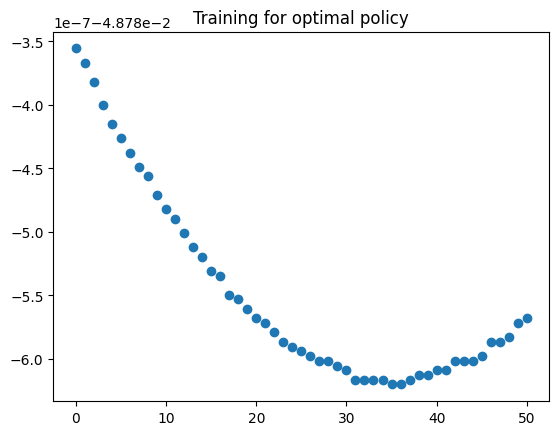

In [51]:
plt.scatter(np.arange(len(loss_history)),np.array(loss_history))
plt.title('Training for optimal policy')
plt.show()

In [52]:
SDL_policy2 = DNN_policy_class(xvar)
SDL_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
SDL_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_SDL_policy']))],epochs=50,batch_size = 32)
# Training loop
num_epochs = 200
inputs = np.array(df_test[xvar])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
# Training loop
loss_history = []
patience = 3 # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_sdl(SDL_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 20)             │         1,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281 (8.91 KB)

 Trainable params: 2,281 (8.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 0.1155 - mae: 0.2576
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.0243 - mae: 0.1238
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step - loss: 0.0198 - mae: 0.1102
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.0189 - mae: 0.1066
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 0.0179 - mae: 0.1040
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 0.0164 - mae: 0.0994
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 0.0140 - mae: 0.0904
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 0.0091 - mae: 0.0713
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 0.0068 - mae: 0.0609
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 0.0059 - mae: 0.0566
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 0.0052 - mae: 0.0528
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 0.0048 - mae: 0.0506
E

In [53]:
SDL_policy_class = tf.squeeze(SDL_policy(inputs))

In [54]:
SDL_policy_class

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([0.77192557, 0.78793204, 0.8902369 , ..., 0.7825835 , 0.713199  ,
       0.7200249 ], dtype=float32)>

## LR

coef of treatment: 0.00000000
coef of treatment: 0.02236423
coef of treatment: 0.06779157
coef of treatment: 0.09399965
coef of treatment: 0.16388787


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - loss: 0.6586 - mae: 0.6549
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.3059 - mae: 0.4453
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.2052 - mae: 0.3642
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.1327 - mae: 0.2941
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 0.0930 - mae: 0.2448
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.0687 - mae: 0.2109
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.0512 - mae: 0.1819
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 0.0420 - mae: 0.1645
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.0349 - mae: 0.1504
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.0307 - mae: 0.1409
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.0276 - mae: 0.1328
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 0.0245 - mae: 0.1259
Epoch 13/20
79/79 ━━━━━━━

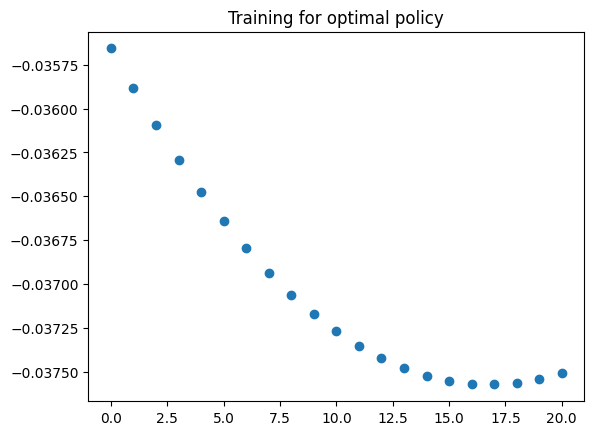

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 20)             │         1,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281 (8.91 KB)

 Trainable params: 2,281 (8.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 0.1312 - mae: 0.2927 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.0369 - mae: 0.1534
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 0.0286 - mae: 0.1346
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.0255 - mae: 0.1264
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.0230 - mae: 0.1193
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 0.0226 - mae: 0.1174
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.0213 - mae: 0.1148
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.0211 - mae: 0.1137
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 0.0202 - mae: 0.1118
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.0193 - mae: 0.1093
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 0.0196 - mae: 0.1091
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 0.0192 - mae: 0.1078
Epoch 13/20
79/79 ━━━━━━

In [55]:

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='sklearn')
reg = LinearRegression(fit_intercept=True).fit(np.array(df_train[xvar+tvar]),np.array(df_train['is_upload']))
#predicted ate:

df_test['tempt'] = 0
base = reg.predict(np.array(df_test[xvar+['tempt']]))
exp_t_values = [0,0.128,0.388,0.538,0.938]
for i in range(5):
    df_test['tempt'] = exp_t_values[i]
    exp = reg.predict(df_test[xvar+['tempt']])
    print('coef of treatment:', '%.8f'%(exp.mean()-base.mean()))
LR_outcome_array=np.zeros((len(df_test),len(t_values)))
for i in range(len(t_values)):
    df_test['tempt']=t_values[i]
    LR_outcome_array[:,i] = reg.predict(df_test[xvar+['tempt']])
LR_value_array = LR_outcome_array*(0.5-author_value*t)
df_test['learned_LR_policy'] = np.argmax(LR_value_array,axis=1)
df_test['LR_est_policy_value'] = np.max(LR_value_array,axis=1)
#within same policy class
# LR_policy = DNN_policy_class(xvar)
LR_policy = linear_policy_class(xvar)
LR_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LR_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_LR_policy']))],epochs=20,batch_size = 128)
def custom_loss_lr(t,reg,df_test):
    df_test['tempt']=t
    psi = reg.predict(df_test[xvar+['tempt']])
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_lr(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_lr(predictions,reg,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3 # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_lr(LR_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

# Print the final model parameters

for var in LR_policy.trainable_variables:
    print(var.name, var.numpy())
plt.scatter(np.arange(len(loss_history)),np.array(loss_history))
plt.title('Training for optimal policy')
plt.show()
LR_policy_class = tf.squeeze(LR_policy(inputs))


LR_policy2 = DNN_policy_class(xvar)
LR_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LR_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)
def custom_loss_lr(t,reg,df_test):
    df_test['tempt']=t
    psi = reg.predict(df_test[xvar+['tempt']])
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_lr(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_lr(predictions,reg,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3 # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_lr(LR_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

## LogR

In [56]:
# LogR
def logistic(xvar,tvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    input2_ = Input(shape=(len(tvar),),name='treatment_input')


    inputall = layers.concatenate([input1_,input2_])
    a = layers.Dense(1,name='output',activation='sigmoid')(inputall)

    model = Model(inputs=[input1_,input2_],outputs=[a])
    model.summary()
    return model
model_logistic = logistic(xvar,tvar)
loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model_logistic.compile(optimizer = opt,loss = loss,metrics=METRICS)
history = model_logistic.fit([dnn_x_train,dnn_t_train],dnn_y_train,epochs=100,batch_size = 128,validation_split=0.1)
#predicted ate:

df_test['tempt'] = 0
base = model_logistic.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
for i in range(5):
    df_test['tempt'] = exp_t_values[i]
    exp = model_logistic.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
    print('coef of treatment:', '%.8f'%(exp.mean()-base.mean()))
import numpy as np

LogR_policy = linear_policy_class(xvar)
LogR_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LogR_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)
def custom_loss_logr(t,model_logistic,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_logistic([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_logr(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_logr(predictions,model_logistic,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_logr(LogR_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0
LogR_policy_class = tf.squeeze(LogR_policy(inputs))

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_input       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 71)        │          0 │ feature_input[0]… │
│ (Concatenate)       │                   │            │ treatment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         72 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 72 (288.00 B)

 Trainable params: 72 (288.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9536 - auc: 0.7926 - fn: 216.4167 - fp: 40.9028 - loss: 0.1898 - prc: 0.2379 - precision: 0.4438 - recall: 0.1516 - tn: 5376.5278 - tp: 33.9306 - val_accuracy: 0.9550 - val_auc: 0.9211 - val_fn: 36.0000 - val_fp: 9.0000 - val_loss: 0.1298 - val_prc: 0.4210 - val_precision: 0.6087 - val_recall: 0.2800 - val_tn: 941.0000 - val_tp: 14.0000
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.9550 - auc: 0.9140 - fn: 167.8333 - fp: 36.6944 - loss: 0.1215 - prc: 0.4108 - precision: 0.5182 - recall: 0.2131 - tn: 4421.0137 - tp: 42.2361 - val_accuracy: 0.9590 - val_auc: 0.9351 - val_fn: 32.0000 - val_fp: 9.0000 - val_loss: 0.1206 - val_prc: 0.4576 - val_precision: 0.6667 - val_recall: 0.3600 - val_tn: 941.0000 - val_tp: 18.0000
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.9622 - auc: 0.9242 - fn: 145.3056 - fp: 32.6528 - loss: 0.1080 - prc: 0.4209 - precision: 0.5943 - recall: 0.2596 - tn: 443

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 0.5978 - mae: 0.6244
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 0.2735 - mae: 0.4144
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.1948 - mae: 0.3525
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.1337 - mae: 0.2910
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 0.0996 - mae: 0.2490
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.0700 - mae: 0.2095
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 0.0552 - mae: 0.1865
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.0468 - mae: 0.1720
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 0.0407 - mae: 0.1599
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.0369 - mae: 0.1517
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 0.0345 - mae: 0.1466
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.0321 - mae: 0.1421
Epoch 13/20
79/79 ━━━━━━━

In [57]:
LogR_policy2 = DNN_policy_class(xvar)
LogR_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LogR_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)
def custom_loss_logr(t,model_logistic,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_logistic([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_logr(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_logr(predictions,model_logistic,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_logr(LogR_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 20)             │         1,420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,281 (8.91 KB)

 Trainable params: 2,281 (8.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 0.3616 - mae: 0.4959 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 0.0464 - mae: 0.1712
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.0319 - mae: 0.1421
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 0.0278 - mae: 0.1318
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.0257 - mae: 0.1264
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.0236 - mae: 0.1207
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step - loss: 0.0226 - mae: 0.1176
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 0.0217 - mae: 0.1147
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 0.0213 - mae: 0.1133
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 0.0197 - mae: 0.1094
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 0.0202 - mae: 0.1103
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 0.0193 - mae: 0.1071
Epoch 13/20
79/79 ━━━━━━

## LCM

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_input       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1)         │         70 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1)         │         70 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u (Add)             │ (None, 1)         │          0 │ dense_30[0][0],   │
│                     │                   │            │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │          2 │ u[0][0]           │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 142 (568.00 B)

 Trainable params: 142 (568.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9367 - auc: 0.6564 - fn: 228.7103 - fp: 100.7703 - loss: 0.3363 - prc: 0.1479 - precision: 0.1943 - recall: 0.1198 - tn: 5190.8589 - tp: 23.3781 - val_accuracy: 0.9500 - val_auc: 0.6855 - val_fn: 50.0000 - val_fp: 0.0000e+00 - val_loss: 0.1915 - val_prc: 0.0908 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 950.0000 - val_tp: 0.0000e+00
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.9558 - auc: 0.6830 - fn: 201.0318 - fp: 0.0000e+00 - loss: 0.1741 - prc: 0.1082 - precision: 0.7951 - recall: 0.0039 - tn: 4341.8906 - tp: 0.7951 - val_accuracy: 0.9500 - val_auc: 0.7899 - val_fn: 50.0000 - val_fp: 0.0000e+00 - val_loss: 0.1730 - val_prc: 0.1586 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 950.0000 - val_tp: 0.0000e+00
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.9573 - auc: 0.7814 - fn: 194.4770 - fp: 0.0000e+00 - loss: 0.1538 - prc: 0.2105 - pr

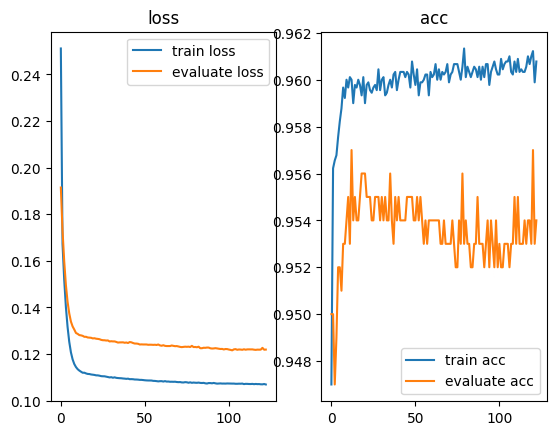

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step
coef of treatment: 0.00000000


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 0.6183 - mae: 0.6286 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.3490 - mae: 0.4745
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.2449 - mae: 0.3971
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.1656 - mae: 0.3272
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.1156 - mae: 0.2744
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.0807 - mae: 0.2294
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.0611 - mae: 0.1990
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.0478 - mae: 0.1761
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 0.0411 - mae: 0.1628
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.0360 - mae: 0.1513
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.0321 - mae: 0.1431
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.0314 - mae: 0.1414
Epoch 13/20
79/79 ━━━━━━

In [58]:

def lcm(xvar,tvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    input2_ = Input(shape=(len(tvar),),name='treatment_input')
    
    a = layers.Dense(1,use_bias = False)(input1_)
    b = layers.Dense(1,use_bias = False)(input1_)
    def custom_multiply_and_sum(inputs):
        parab, t = inputs
        return tf.reduce_sum(parab * t, axis=-1, keepdims=True) 

    bt = tf.keras.layers.Lambda(custom_multiply_and_sum)([b, t])
    abt = layers.Add(name='u')([a,bt])
    # abcdt = layers.Add(name='u')([paraa,bbt])
    u = layers.Dense(1,name='output',activation='sigmoid')(abt)

    model = Model(inputs=[input1_,input2_],outputs=[u])
    model.summary()
    return model

model_lcm = lcm(xvar,tvar)
loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lcm.compile(optimizer = opt,loss = loss,metrics=METRICS)
history = model_lcm.fit([dnn_x_train,dnn_t_train],dnn_y_train,epochs=200,batch_size = 32,validation_split=0.1,callbacks=[early_stopping])
loss = history.history['loss']  # 测试集损失
acc = history.history['accuracy']  # 测试集准确率
val_loss = history.history['val_loss']  # 验证集损失
val_acc = history.history['val_accuracy']  # 验证集准确率|
plt.figure()
plt.subplot(121)
plt.plot(loss,label='train loss')
plt.plot(val_loss,label = 'evaluate loss')
plt.legend()
plt.title('loss')
plt.subplot(122)
plt.plot(acc,label='train acc')
plt.plot(val_acc,label = 'evaluate acc')
plt.legend()
plt.title('acc')
plt.show()


#predicted ate:
df_test['tempt'] = 0
base = model_lcm.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
for i in range(5):
    df_test['tempt'] = exp_t_values[i]
    exp = model_lcm.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
    print('coef of treatment:', '%.8f'%(exp.mean()-base.mean()))


LCM_policy = linear_policy_class(xvar)
LCM_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LCM_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss_pdl(t,model_pdl,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_pdl([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_pdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_pdl(predictions,model_lcm,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_pdl(LCM_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0
LCM_policy_class = tf.squeeze(LCM_policy(inputs))

In [59]:
LCM_policy2 = linear_policy_class(xvar)
LCM_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
LCM_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss_pdl(t,model_pdl,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_pdl([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_pdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_pdl(predictions,model_lcm,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_pdl(LCM_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 1.0648 - mae: 0.8890 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.3088 - mae: 0.4455
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.2049 - mae: 0.3632
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.1590 - mae: 0.3201
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 0.1314 - mae: 0.2928
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.1044 - mae: 0.2587
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.0886 - mae: 0.2381
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.0747 - mae: 0.2186
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 0.0614 - mae: 0.1994
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 0.0562 - mae: 0.1904
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.0477 - mae: 0.1745
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 0.0419 - mae: 0.1632
Epoch 13/20
79/79 ━━━━━━

## PDL

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ feature_input       │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ treatment_input     │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 71)        │          0 │ feature_input[0]… │
│ (Concatenate)       │                   │            │ treatment_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 10)        │        720 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 10)        │        110 │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 10)        │        110 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         11 │ dense_36[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 951 (3.71 KB)

 Trainable params: 951 (3.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6916 - auc: 0.5321 - fn: 182.6996 - fp: 1454.9010 - loss: 0.6804 - prc: 0.0995 - precision: 0.0421 - recall: 0.2669 - tn: 3848.7385 - tp: 57.3781 - val_accuracy: 0.9470 - val_auc: 0.4728 - val_fn: 49.0000 - val_fp: 4.0000 - val_loss: 0.5564 - val_prc: 0.0564 - val_precision: 0.2000 - val_recall: 0.0200 - val_tn: 946.0000 - val_tp: 1.0000
Epoch 2/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.9558 - auc: 0.4510 - fn: 199.2014 - fp: 3.6996 - loss: 0.4936 - prc: 0.0384 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 4340.8164 - tp: 0.0000e+00 - val_accuracy: 0.9500 - val_auc: 0.5385 - val_fn: 50.0000 - val_fp: 0.0000e+00 - val_loss: 0.3202 - val_prc: 0.0567 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 950.0000 - val_tp: 0.0000e+00
Epoch 3/200
282/282 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.9544 - auc: 0.5476 - fn: 202.9223 - fp: 0.0000e+00 - loss: 0.2756 - prc: 0.0500 - precision

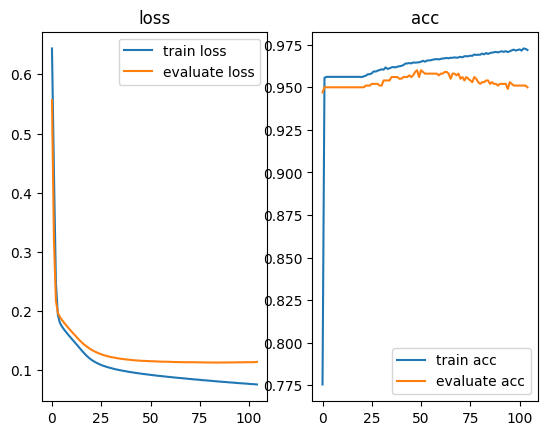

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
coef of treatment: 0.00000000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
coef of treatment: 0.00916780
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step
coef of treatment: 0.03938284
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
coef of treatment: 0.06588019
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 277us/step
coef of treatment: 0.17310970


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.4928 - mae: 0.5567 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 0.2956 - mae: 0.4319
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 0.1825 - mae: 0.3406
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 0.1142 - mae: 0.2718
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.0742 - mae: 0.2183
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.0530 - mae: 0.1852
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 0.0403 - mae: 0.1610
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 0.0346 - mae: 0.1496
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.0314 - mae: 0.1413
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.0292 - mae: 0.1364
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - loss: 0.0275 - mae: 0.1318
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - loss: 0.0263 - mae: 0.1279
Epoch 13/20
79/79 ━━━━━━

In [60]:
# PDL
def pdl(xvar,tvar):
    input1_ = Input(shape=(len(xvar),),name='feature_input')
    input2_ = Input(shape=(len(tvar),),name='treatment_input')

#     initializer = tf.keras.initializers.GlorotUniform()
    inputall = layers.concatenate([input1_,input2_])
    a = layers.Dense(10,activation='relu')(inputall)
    a = layers.Dense(10,activation='relu')(a)
    a = layers.Dense(10,activation='relu')(a)
    a = layers.Dense(1,name='output',activation='sigmoid')(a)

    model = Model(inputs=[input1_,input2_],outputs=[a])
    model.summary()
    return model
model_pdl = pdl(xvar,tvar)
loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_pdl.compile(optimizer = opt,loss = loss,metrics=METRICS)
history = model_pdl.fit([dnn_x_train,dnn_t_train],dnn_y_train,epochs=200,batch_size = 32,validation_split=0.1,callbacks=[early_stopping])
loss = history.history['loss']  # 测试集损失
acc = history.history['accuracy']  # 测试集准确率
val_loss = history.history['val_loss']  # 验证集损失
val_acc = history.history['val_accuracy']  # 验证集准确率|
plt.figure()
plt.subplot(121)
plt.plot(loss,label='train loss')
plt.plot(val_loss,label = 'evaluate loss')
plt.legend()
plt.title('loss')
plt.subplot(122)
plt.plot(acc,label='train acc')
plt.plot(val_acc,label = 'evaluate acc')
plt.legend()
plt.title('acc')
plt.show()


#predicted ate:
df_test['tempt'] = 0
base = model_pdl.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
for i in range(5):
    df_test['tempt'] = exp_t_values[i]
    exp = model_pdl.predict([np.array(df_test[xvar]),np.array(df_test['tempt'])])
    print('coef of treatment:', '%.8f'%(exp.mean()-base.mean()))
# PDL_outcome_array = np.zeros((len(df_test),len(t_values)))
# for i in range(len(t_values)):
#     df_test['tempt']=t_values[i]
#     PDL_outcome_array[:,i]=model_pdl.predict([df_test[xvar],df_test['tempt']]).reshape(-1)
# PDL_outcome_array = model_pdl.predict(combined_input).reshape(len(t_values), len(df_test)).T
# PDL_value_array = PDL_outcome_array*(0.5 - author_value*t_values)
# df_test['learned_PDL_policy'] = np.argmax(PDL_value_array,axis=1)
# df_test['PDL_est_policy_value'] = np.max(PDL_value_array,axis=1)
# print(df_test['PDL_est_policy_value'].mean())
#within same policy class
# PDL_policy = DNN_policy_class(xvar)
PDL_policy = linear_policy_class(xvar)
PDL_policy.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
PDL_policy.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss_pdl(t,model_pdl,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_pdl([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_pdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_pdl(predictions,model_pdl,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_pdl(PDL_policy, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0
PDL_policy_class = tf.squeeze(PDL_policy(inputs))

In [61]:
PDL_policy2 = linear_policy_class(xvar)
PDL_policy2.compile(optimizer = 'adam',loss = 'mse',metrics=['mae'])
PDL_policy2.fit(np.array(df_test[xvar]),t_values[list(np.array(df_test['learned_DLPT_policy']))],epochs=20,batch_size = 128)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss_pdl(t,model_pdl,df_test):
    df_test['tempt']=t
    x_data = tf.convert_to_tensor(df_test[xvar].values, dtype=tf.float32)
    t_data = tf.convert_to_tensor(df_test['tempt'].values, dtype=tf.float32)
    psi = model_pdl([x_data,t_data], training=False)
    value = psi*(0.5-author_value*t)
    return -tf.reduce_mean(value)
def train_step_pdl(model, inputs,optimizer):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        predictions = tf.squeeze(predictions)
        loss = custom_loss_pdl(predictions,model_pdl,df_test)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Training parameters
num_epochs = 200
inputs = np.array(df_test[xvar])
# Training loop
loss_history = []
patience = 3  # Number of epochs to wait before stopping after loss starts increasing
trigger_times = 0  # Counter for the number of times loss has increased consecutively

for epoch in range(num_epochs):
    loss = train_step_pdl(PDL_policy2, inputs, optimizer)
    print(f'Epoch {epoch}: Loss: {loss.numpy()}')
    loss_history.append(loss.numpy())

    # Check if the current loss is greater than the previous one (after the first epoch)
    if epoch > 0 and loss_history[-1] > loss_history[-2]:
        trigger_times += 1
        print(f"Loss increased! Trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping triggered due to increased loss.")
            break
    else:
        # Reset the trigger if the loss decreases
        trigger_times = 0

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_input (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.4866 - mae: 0.5565 
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 0.2689 - mae: 0.4136
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 0.1759 - mae: 0.3325
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 0.1138 - mae: 0.2705
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 0.0789 - mae: 0.2257
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - loss: 0.0564 - mae: 0.1908
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 0.0458 - mae: 0.1714
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.0377 - mae: 0.1558
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.0348 - mae: 0.1494
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.0323 - mae: 0.1431
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 0.0292 - mae: 0.1364
Epoch 12/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - loss: 0.0283 - mae: 0.1338
Epoch 13/20
79/79 ━━━━━━

## AVG

In [62]:
AVG_outcome_array = np.array(df_train.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
obs_tvalues = np.array(df_train.groupby('t')['is_upload'].mean().reset_index()['t'])
AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
df_test['learned_AVG_policy'] = np.argmax(AVG_value_array)

In [63]:
AVG_value_array

array([0.00674326, 0.00860687, 0.01420913, 0.02075504, 0.036462  ])

## GROUP

In [64]:
df_test['learned_rightGROUP_policy'] = 0
for i in range(df_train['right_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['right_groupidx']==i]
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_test.loc[df_test['right_groupidx']==i,'learned_rightGROUP_policy']=np.argmax(AVG_value_array)

In [65]:
# df_test['learned_wrongGROUP_policy'] = 0
for i in range(df_train['wrong_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['wrong_groupidx']==i]
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_test.loc[df_test['wrong_groupidx']==i,'learned_wrongGROUP_policy']=np.argmax(AVG_value_array)

## OOS RESULT

### Linear Policy Class

In [69]:
# OOS RESULT
oos_DLPT = tf.clip_by_value(tf.squeeze(DLPT_policy(x_validation)),0,1)
df_val['learned_DLPT_Class_policy']=oos_DLPT
oos_SDL = tf.clip_by_value(tf.squeeze(SDL_policy(x_validation)),0,1)
oos_LR = tf.clip_by_value(tf.squeeze(LR_policy(x_validation)),0,1)
oos_LogR = tf.clip_by_value(tf.squeeze(LogR_policy(x_validation)),0,1)
oos_LCM = tf.clip_by_value(tf.squeeze(LCM_policy(x_validation)),0,1)
oos_PDL = tf.clip_by_value(tf.squeeze(PDL_policy(x_validation)),0,1)
df_val['learned_AVG_policy']=np.argmax(AVG_value_array)
df_val['learned_rightGROUP_policy'] = 0
for i in range(df_train['right_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['right_groupidx']==i]
    a = df_train_group[f'Feature_{C+1}'].mean()
    b = df_train_group[f'Feature_{C+2}'].mean()
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_val.loc[(df_val[f'Feature_{C+1}']==a)&(df_val[f'Feature_{C+2}']==b),'learned_rightGROUP_policy']=np.argmax(AVG_value_array)

df_val['learned_wrongGROUP_policy'] = 0
for i in range(df_train['wrong_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['wrong_groupidx']==i]
    a = df_train_group[f'Feature_{C+3}'].mean()
    b = df_train_group[f'Feature_{C+4}'].mean()
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_val.loc[(df_val[f'Feature_{C+3}']==a)&(df_val[f'Feature_{C+4}']==b),'learned_wrongGROUP_policy']=np.argmax(AVG_value_array)

df_val['DLPT_Class_true_policy_value']=r(np.array(oos_DLPT),alpha_val,beta_val,theta_val,gamma_val)
df_val['SDL_Class_true_policy_value']=r(np.array(oos_SDL),alpha_val,beta_val,theta_val,gamma_val)
df_val['LR_Class_true_policy_value']=r(np.array(oos_LR),alpha_val,beta_val,theta_val,gamma_val)
df_val['LogR_Class_true_policy_value']=r(np.array(oos_LogR),alpha_val,beta_val,theta_val,gamma_val)
df_val['LCM_Class_true_policy_value']=r(np.array(oos_LCM),alpha_val,beta_val,theta_val,gamma_val)
df_val['PDL_Class_true_policy_value']=r(np.array(oos_PDL),alpha_val,beta_val,theta_val,gamma_val)
df_val['AVG_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_AVG_policy']))],alpha_val,beta_val,theta_val,gamma_val)
df_val['wrongGROUP_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_wrongGROUP_policy']))],alpha_val,beta_val,theta_val,gamma_val)
df_val['rightGROUP_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_rightGROUP_policy']))],alpha_val,beta_val,theta_val,gamma_val)

print('true optimal policy value:',df_val['optimal_r'].sum())
print('LogR policy value: ',df_val['LogR_Class_true_policy_value'].sum())
print('SDL policy value: ',df_val['SDL_Class_true_policy_value'].sum())
print('DLPT policy value: ',df_val['DLPT_Class_true_policy_value'].sum())
print('LR policy value: ',df_val['LR_Class_true_policy_value'].sum())
print('AVG policy value: ',df_val['AVG_true_policy_value'].sum())
print('wrong GROUP policy value: ',df_val['wrongGROUP_true_policy_value'].sum())
print('right GROUP policy value: ',df_val['rightGROUP_true_policy_value'].sum())
print('LCM policy value: ',df_val['LCM_Class_true_policy_value'].sum())
print('PDL policy value: ',df_val['PDL_Class_true_policy_value'].sum())


true optimal policy value: 274.43243365842494
LogR policy value:  195.85889
SDL policy value:  211.02896
DLPT policy value:  210.75992
LR policy value:  182.9227
AVG policy value:  118.51646827747257
wrong GROUP policy value:  118.51646827747257
right GROUP policy value:  118.51646827747257
noise GROUP policy value:  118.51646827747257
rightnoise GROUP policy value:  118.51646827747257
LCM policy value:  48.303177
PDL policy value:  200.54645


### DNN Policy Class

In [71]:
# OOS RESULT
oos_DLPT = tf.clip_by_value(tf.squeeze(DLPT_policy2(x_validation)),0,1)
df_val['learned_DLPT_Class_policy']=oos_DLPT
oos_SDL = tf.clip_by_value(tf.squeeze(SDL_policy2(x_validation)),0,1)
oos_LR = tf.clip_by_value(tf.squeeze(LR_policy2(x_validation)),0,1)
oos_LogR = tf.clip_by_value(tf.squeeze(LogR_policy2(x_validation)),0,1)
oos_LCM = tf.clip_by_value(tf.squeeze(LCM_policy2(x_validation)),0,1)
oos_PDL = tf.clip_by_value(tf.squeeze(PDL_policy2(x_validation)),0,1)
df_val['learned_AVG_policy']=np.argmax(AVG_value_array)
df_val['learned_rightGROUP_policy'] = 0
for i in range(df_train['right_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['right_groupidx']==i]
    a = df_train_group[f'Feature_{C+1}'].mean()
    b = df_train_group[f'Feature_{C+2}'].mean()
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_val.loc[(df_val[f'Feature_{C+1}']==a)&(df_val[f'Feature_{C+2}']==b),'learned_rightGROUP_policy']=np.argmax(AVG_value_array)

df_val['learned_wrongGROUP_policy'] = 0
for i in range(df_train['wrong_groupidx'].nunique()):
    df_train_group = df_train.loc[df_train['wrong_groupidx']==i]
    a = df_train_group[f'Feature_{C+3}'].mean()
    b = df_train_group[f'Feature_{C+4}'].mean()
    AVG_outcome_array = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['is_upload'])
    obs_tvalues = np.array(df_train_group.groupby('t')['is_upload'].mean().reset_index()['t'])
    AVG_value_array=AVG_outcome_array*(0.5 - author_value* obs_tvalues)
    df_val.loc[(df_val[f'Feature_{C+3}']==a)&(df_val[f'Feature_{C+4}']==b),'learned_wrongGROUP_policy']=np.argmax(AVG_value_array)


df_val['DLPT_Class_true_policy_value']=r(np.array(oos_DLPT),alpha_val,beta_val,theta_val,gamma_val)
df_val['SDL_Class_true_policy_value']=r(np.array(oos_SDL),alpha_val,beta_val,theta_val,gamma_val)
df_val['LR_Class_true_policy_value']=r(np.array(oos_LR),alpha_val,beta_val,theta_val,gamma_val)
df_val['LogR_Class_true_policy_value']=r(np.array(oos_LogR),alpha_val,beta_val,theta_val,gamma_val)
df_val['LCM_Class_true_policy_value']=r(np.array(oos_LCM),alpha_val,beta_val,theta_val,gamma_val)
df_val['PDL_Class_true_policy_value']=r(np.array(oos_PDL),alpha_val,beta_val,theta_val,gamma_val)
df_val['AVG_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_AVG_policy']))],alpha_val,beta_val,theta_val,gamma_val)
df_val['wrongGROUP_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_wrongGROUP_policy']))],alpha_val,beta_val,theta_val,gamma_val)
df_val['rightGROUP_true_policy_value']=r(obs_tvalues[list(np.array(df_val['learned_rightGROUP_policy']))],alpha_val,beta_val,theta_val,gamma_val)


print('true optimal policy value:',df_val['optimal_r'].sum())
print('LogR policy value: ',df_val['LogR_Class_true_policy_value'].sum())
print('SDL policy value: ',df_val['SDL_Class_true_policy_value'].sum())
print('DLPT policy value: ',df_val['DLPT_Class_true_policy_value'].sum())
print('LR policy value: ',df_val['LR_Class_true_policy_value'].sum())
print('AVG policy value: ',df_val['AVG_true_policy_value'].sum())
print('wrong GROUP policy value: ',df_val['wrongGROUP_true_policy_value'].sum())
print('right GROUP policy value: ',df_val['rightGROUP_true_policy_value'].sum())
print('LCM policy value: ',df_val['LCM_Class_true_policy_value'].sum())
print('PDL policy value: ',df_val['PDL_Class_true_policy_value'].sum())


20000 274.43243365842494 219.21567 220.22592 223.01346 160.1369 118.51646827747257 198.70067 118.51646827747257 118.51646827747257 118.51646827747257 118.51646827747257 48.148285


### Discretized Continuous Policy Class

In [72]:
#DLPT and SDL
x_train_s = df_val
modelu = Model(inputs=model_cubic_random_mask.input, outputs=model_cubic_random_mask.get_layer('u').output)
dnn_x_test = x_train_s[xvar]
f = x_train_s.groupby(tvar)['Feature_1'].count().reset_index()
sumt = f['Feature_1'].sum()
F_list = f['Feature_1']/sumt

aa2 = np.zeros((len(x_train_s),4,4))
# #use mse as loss
# for i in range(len(f)):
#     t = f[tvar[0]][i]
#     tildet = np.hstack((1,t,t*t,t*t*t))#[1,t,t^2]
#     u = np.array(modelu.predict([x_train_s[xvar],np.array([t]*len(x_train_s))])).reshape(-1)
#     for j in range(len(x_train_s)):
#         # loss_weights = x_train_s['is_upload'][j]*class_weights[1] + (1- x_train_s['is_upload'][j])*class_weights[0]
#         g_prime =  (np.exp(-u[j])/((1+np.exp(-u[j]))**2))*tildet
#         l_pp =np.outer(g_prime,g_prime)*F_list[i]
#         aa2[j] += l_pp

#use binary crossentropy as loss
for i in range(len(f)):
    t = f[tvar[0]][i]
    tildet = np.hstack((1,t,t*t,t*t*t))#[1,t,t^2]
    u = np.array(modelu.predict([x_train_s[xvar],np.array([t]*len(x_train_s))])).reshape(-1)
    for j in range(len(x_train_s)):
        # loss_weights = x_train_s['is_upload'][j]*class_weights[1] + (1- x_train_s['is_upload'][j])*class_weights[0]
        l_pp = (np.exp(-u[j])/((1+np.exp(-u[j]))**2))*np.outer(tildet,tildet)*F_list[i]
        aa2[j] += l_pp
        
cc2=np.zeros((len(x_train_s),4,4))
notinv=[]
for i in range(aa2.shape[0]):
    try:
        cc2[i]=np.linalg.inv(aa2[i]+0.01*np.eye(aa2[0].shape[0]))
    except:
        notinv.append(i)
        cc2[i]=np.linalg.inv(aa2[i]+0.005*np.eye(aa2[0].shape[0]))
# print('lambda inv done.')
# print(len(notinv))

modela = Model(model_cubic_random_mask.input, model_cubic_random_mask.get_layer('parameter_a').output)
modelb = Model(model_cubic_random_mask.input, model_cubic_random_mask.get_layer('parameter_bcd').output)

resdf = pd.DataFrame()
resdf['a'] = modela.predict([df_val[xvar], np.array([0]*len(df_val))]).reshape(-1)
a = np.array(resdf['a'])
b = modelb.predict([df_val[xvar], np.array([0]*len(df_val))])
resdf['b1'] = b[:,0]
resdf['b2'] = b[:,1]
resdf['b3'] = b[:,2]
resdf['prey_real'] = model_cubic_random_mask.predict([df_val[xvar], np.array([0]*len(df_val))]).reshape(-1)
resdf['preu_real'] = modelu.predict([df_val[xvar], np.array([0]*len(df_val))]).reshape(-1)

resdf['dGpreu_real'] = g_dao(np.array(resdf['preu_real']))

resdf['y'] = df_val['y']
# resdf['loss_weight'] = resdf['y']*class_weights[1] + (1-resdf['y'])*class_weights[0]
# resdf['g_y'] = (resdf['prey_real']-resdf['y'])
resdf['g_y'] = (resdf['prey_real']-resdf['y'])
# resdf['l1'] = resdf['g_y']*resdf['dGpreu_real']
resdf['l1'] = resdf['g_y']
resdf['lt1'] = np.array(df_val[tvar]).reshape(-1)*np.array(resdf['l1']).reshape(-1)
resdf['lt2'] = np.array(df_val[tvar]).reshape(-1)*np.array(resdf['lt1']).reshape(-1)
resdf['lt3'] = np.array(df_val[tvar]).reshape(-1)*np.array(resdf['lt2']).reshape(-1)
ltheta = np.array(resdf[['l1', 'lt1', 'lt2', 'lt3']])
ltheta = ltheta.reshape((len(df_val),4,1))

gu, psi = objective(t_values, a, b, cc2, ltheta)
psi_array_DLPT = psi  # Transpose to match the expected shape (num_samples, len(t_values))
psi_array_SDL = gu  # Assuming you need the same values here; adjust if necessary
SDL_value_array = psi_array_SDL*(0.5 - author_value*t_values)
DLPT_value_array=psi_array_DLPT*(0.5 - author_value*t_values)
df_val['learned_SDL_policy'] = np.argmax(SDL_value_array,axis=1)
df_val['learned_DLPT_policy'] = np.argmax(DLPT_value_array,axis=1)

# print('SDL and DLPT done.')

# LR
LR_outcome_array = np.zeros((len(df_val), len(t_values)))
for i in range(len(t_values)):
    df_val['tempt'] = t_values[i]
    LR_outcome_array[:, i] = reg.predict(df_val[xvar + ['tempt']])
LR_value_array = LR_outcome_array*(0.5 - author_value*t_values)
df_val['learned_LR_policy'] = np.argmax(LR_value_array, axis=1)
# print('LR done.')

def predict_in_batches(model, batch_size=10):
    outcome_array = []
    # Iterate over batches
    batch_size = 500
    for start in range(0, len(df_val), batch_size):
        end = start + batch_size
        tvalues_repeated = np.repeat(t_values, batch_size)
        df_val_repeated = np.tile(np.array(df_val[xvar])[start:end,:], (len(t_values), 1))
        combined_input = [df_val_repeated, tvalues_repeated]
        # Predict for the current batch
        batch_predictions = model.predict(combined_input).reshape(-1)
        outcome_array.append(batch_predictions)
    return np.vstack(outcome_array)


# LogR
LogR_outcome_array = predict_in_batches(model_logistic).reshape(len(t_values), len(df_val)).T
LogR_value_array = LogR_outcome_array*(0.5 - author_value*t_values)
df_val['learned_LogR_policy'] = np.argmax(LogR_value_array, axis=1)
# print('LogR done.')

#LCM
LCM_outcome_array = predict_in_batches(model_lcm).reshape(len(t_values), len(df_val)).T
LCM_value_array = LCM_outcome_array * (0.5 - author_value * np.array(t_values))
df_val['learned_LCM_policy'] = np.argmax(LCM_value_array, axis=1)
# print('LCM done.')

# PDL
PDL_outcome_array = predict_in_batches(model_pdl).reshape(len(t_values), len(df_val)).T
PDL_value_array = PDL_outcome_array*(0.5 - author_value*t_values)
df_val['learned_PDL_policy'] = np.argmax(PDL_value_array, axis=1)
# print('PDL done.')

df_val['LR_true_policy_value'] = r(t_values[list(np.array(df_val['learned_LR_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['LogR_true_policy_value'] = r(t_values[list(np.array(df_val['learned_LogR_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['LCM_true_policy_value'] = r(t_values[list(np.array(df_val['learned_LCM_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['PDL_true_policy_value'] = r(t_values[list(np.array(df_val['learned_PDL_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['SDL_true_policy_value'] = r(t_values[list(np.array(df_val['learned_SDL_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['DLPT_true_policy_value'] = r(t_values[list(np.array(df_val['learned_DLPT_policy']))], alpha_val, beta_val, theta_val, gamma_val)


print(N,df_val['optimal_r'].sum(),\
      df_val['SDL_true_policy_value'].sum(),\
      df_val['DLPT_true_policy_value'].sum(),\
      df_val['LR_true_policy_value'].sum(),\
      df_val['LogR_true_policy_value'].sum(),\
      df_val['AVG_true_policy_value'].sum(),\
      df_val['PDL_true_policy_value'].sum(),\
      df_val['wrongGROUP_true_policy_value'].sum(),\
      df_val['rightGROUP_true_policy_value'].sum(),\
      df_val['LCM_true_policy_value'].sum()
    )


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 249us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 249us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 246us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 245us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 249us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 256us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 250us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 252us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 259us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 259us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 259us/step
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 4s 260us/step
20000 274.43243365842494 219.94809384029602 220.39793952761843 217.63702310977408 119.72292962276143 118.51646827747257 136.24954844327817 118.51646827747257 118.51646827747257 118.51646827747257 118.51646827747257 102.283968256764

### Finite Observed Policy Class

In [73]:
gu, psi = objective(obs_tvalues, a, b, cc2, ltheta)
psi_array_DLPT = psi  # Transpose to match the expected shape (num_samples, len(obs_tvalues))
psi_array_SDL = gu  # Assuming you need the same values here; adjust if necessary
SDL_value_array = psi_array_SDL*(0.5 - author_value*obs_tvalues)
DLPT_value_array = psi_array_DLPT*(0.5 - author_value*obs_tvalues)
df_val['learned_SDL_policy'] = np.argmax(SDL_value_array, axis=1)
df_val['learned_DLPT_policy'] = np.argmax(DLPT_value_array, axis=1)

# LR
LR_outcome_array = np.zeros((len(df_val), len(obs_tvalues)))
for i in range(len(obs_tvalues)):
    df_val['tempt'] = obs_tvalues[i]
    LR_outcome_array[:, i] = reg.predict(df_val[xvar + ['tempt']])
LR_value_array = LR_outcome_array*(0.5 - author_value*obs_tvalues)
df_val['learned_LR_policy'] = np.argmax(LR_value_array, axis=1)

# LogR
# Broadcast obs_tvalues across df_val rows
obs_tvalues_repeated = np.repeat(obs_tvalues, len(df_val))
df_val_repeated = np.tile(df_val[xvar].values, (len(obs_tvalues), 1))
combined_input = [df_val_repeated, obs_tvalues_repeated]
LogR_outcome_array = model_logistic.predict(combined_input).reshape(len(obs_tvalues), len(df_val)).T

LogR_value_array = LogR_outcome_array*(0.5 - author_value*obs_tvalues)
df_val['learned_LogR_policy'] = np.argmax(LogR_value_array, axis=1)

# LCM
LCM_outcome_array = model_lcm.predict(combined_input).reshape(len(obs_tvalues), len(df_val)).T
LCM_value_array = LCM_outcome_array*(0.5 - author_value*obs_tvalues)
df_val['learned_LCM_policy'] = np.argmax(LCM_value_array, axis=1)

# PDL
PDL_outcome_array = model_pdl.predict(combined_input).reshape(len(obs_tvalues), len(df_val)).T
PDL_value_array = PDL_outcome_array*(0.5 - author_value*obs_tvalues)
df_val['learned_PDL_policy'] = np.argmax(PDL_value_array, axis=1)


df_val['LR_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_LR_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['LogR_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_LogR_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['LCM_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_LCM_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['PDL_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_PDL_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['SDL_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_SDL_policy']))], alpha_val, beta_val, theta_val, gamma_val)
df_val['DLPT_true_policy_value'] = r(obs_tvalues[list(np.array(df_val['learned_DLPT_policy']))], alpha_val, beta_val, theta_val, gamma_val)


print(N, df_val['optimal_r'].sum(),\
      df_val['SDL_true_policy_value'].sum(),\
      df_val['DLPT_true_policy_value'].sum(),\
      df_val['LR_true_policy_value'].sum(),\
      df_val['LogR_true_policy_value'].sum(),\
      df_val['AVG_true_policy_value'].sum(),\
      df_val['PDL_true_policy_value'].sum(),\
      df_val['wrongGROUP_true_policy_value'].sum(),\
      df_val['rightGROUP_true_policy_value'].sum(),\
      df_val['LCM_true_policy_value'].sum())



313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step
20000 274.43243365842494 118.1724163184031 117.85757678123336 117.22490899506428 118.50634398482032 118.51646827747257 116.87074259294607 118.51646827747257 118.51646827747257 118.51646827747257 118.51646827747257 47.453777942899166
